# Boinformatics Note Implementation

## Outline

1. Upload one patient cohort data

2. Plot histogram of protein values across all samples

3. Upload 3 patient cohort data into IntegratedCohort

4. Compute ROC curve using patient biomarker data predicting the treatment (use L1-regularized Logistic Regression model). 

In [1]:
import cohorts
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
top = "./"
data_dirs = { 'my_cohort' : "../data/" }
file_dirs = { 'my_cohort' : top+"sample_data/" }
replicates_files = { 'my_cohort' : "df_replicates.tsv" }
#sample_files = { 'my_cohort' : "df_samples.tsv" }
sample_groups_files = { 'my_cohort' : "df_sample_groups.tsv" }
cohort = { 'my_cohort' : 'my_cohort' }
references = { 'my_cohort' : 'ref' }
treatments = { 'my_cohort' : 'trt' }
cohort_name = 'my_cohort'
c = cohorts.Cohort(cohort=cohort[cohort_name],marker_type="protein",
                       data_dir=data_dirs[cohort_name],file_dir=file_dirs[cohort_name],
                       replicates_file=replicates_files[cohort_name],
                       #sample_files=sample_files[cohort],
                       sample_groups_file=sample_groups_files[cohort_name],
                       reference=references[cohort_name],
                       treatment=treatments[cohort_name])

In [3]:
display(c.raw_samples.head())
prot_vals = c.raw_samples.reset_index().melt(id_vars='protein')
display(prot_vals.head())

sample,S10,S1,S2,S3,S4,S5,S6,S7,S8,S9
protein,,,,,,,,,,
E7EX29,13.968027,5.951095,0.987186,2.475809,0.210135,2.958997,39.302609,34.555749,9.459432,12.658650
P03950,3.989224,1.545593,3.375510,2.040744,1.377882,3.924505,31.960629,21.130456,2.720350,29.143594
P05067,9.829172,2.254873,1.508200,0.474550,1.631372,2.213939,20.049632,6.879270,7.871361,4.454191
P08253,25.459296,0.893088,4.211167,1.611220,2.563040,0.848135,32.085710,4.686549,16.674894,12.779946
P15144,19.717597,3.055350,3.956229,1.081227,0.987160,0.456139,3.737529,43.609332,39.157259,33.533995


,protein,sample,value
0,E7EX29,S10,13.968027
1,P03950,S10,3.989224
2,P05067,S10,9.829172
3,P08253,S10,25.459296
4,P15144,S10,19.717597


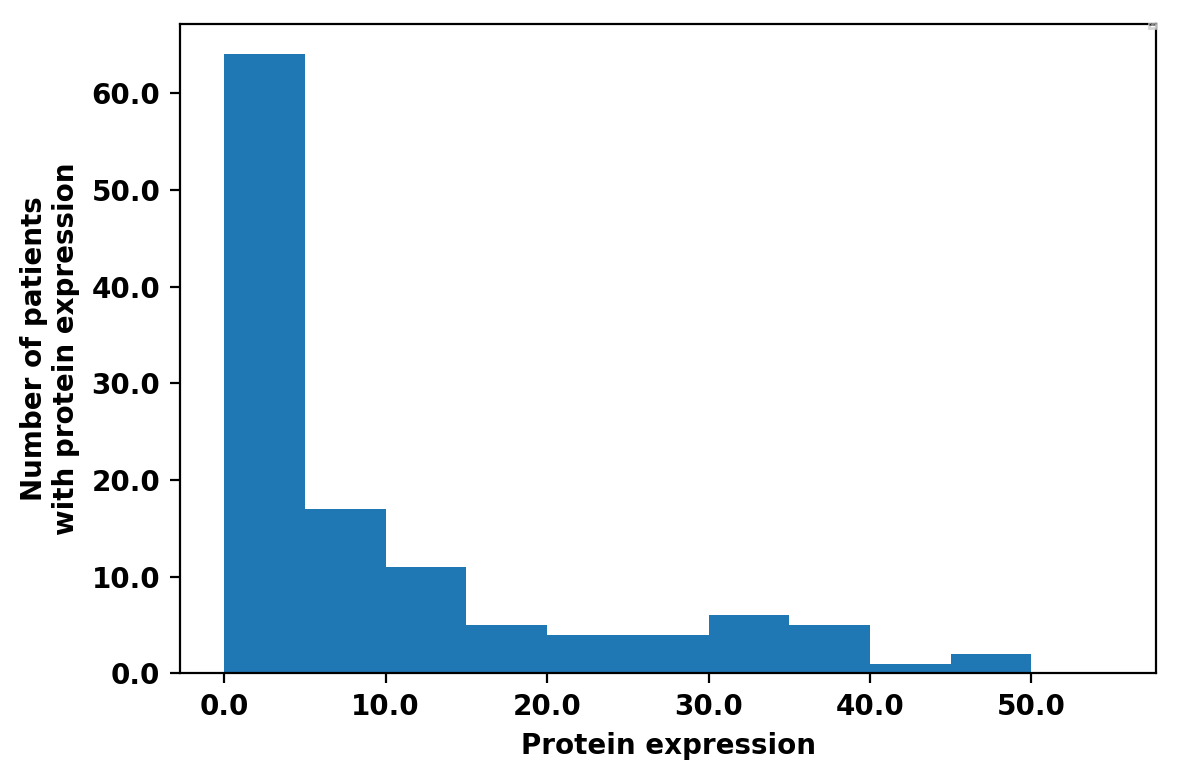

In [4]:
g = prot_vals.plot.hist('value',bins=np.arange(0,prot_vals['value'].max(),5))
g.figure.dpi = 200
g.axes.set_xlabel('Protein expression',fontweight='bold')
g.axes.set_ylabel('Number of patients\nwith protein expression',fontweight='bold')
g.axes.set_yticklabels([np.round(k,2) for k in g.axes.get_yticks()],fontweight='bold')
g.axes.set_xticklabels([np.round(k,2) for k in g.axes.get_xticks()],fontweight='bold')
g.axes.legend(prop={'size' : 0})
g.figure.tight_layout()
g.figure.savefig('figures/protein_expression.pdf')

In [5]:
top = "./"
cohort_names = ['patient_cohort_1','patient_cohort_2','patient_cohort_3']

data_dirs = {}
for cohort in cohort_names:
    data_dirs[cohort] = top+"sample_data/"+cohort
    
file_dirs = {}
for cohort in cohort_names:
    file_dirs[cohort] = top+"sample_data/"+cohort+"/"

replicates_files = {}
for cohort in cohort_names:
    replicates_files[cohort] = "df_replicates.tsv"

#samples_files = {}
#for cohort in cohort_names:
#    samples_files[cohort] = "df_samples.tsv"

sample_groups_files = {}
for cohort in cohort_names:
    sample_groups_files[cohort] = "df_sample_groups.tsv"
    
references = {}
for cohort in cohort_names:
    references[cohort] = "ref"
    
treatments = {}
for cohort in cohort_names:
    treatments[cohort] = "trt"

objs = {}
for cohort_name in cohort_names:
    objs[cohort_name] = cohorts.Cohort(cohort=cohort_name,
                                       marker_type="protein",
                                       data_dir=data_dirs[cohort_name],
                                       file_dir=file_dirs[cohort_name],
                                       replicates_file=replicates_files[cohort_name],
                                       #sample_files=sample_files[cohort],
                                       sample_groups_file= \
                                           sample_groups_files[cohort_name],
                                       reference=references[cohort_name],
                                       treatment=treatments[cohort_name])

In [6]:
integrated = cohorts.IntegratedCohort(cohorts = objs)

In [7]:
integrated.integrate_cohorts(dataset_type='raw_samples')

In [8]:
X = integrated.df.T

In [9]:
Y = integrated.df_groups.loc['trt']

In [10]:
display(X.head())
display(Y.head())

protein,E7EX29,P03950,P05067,P08253,P15144,P27338,P52209,P62191,Q8N302,Q99460,Q9UJX5,Q9Y5C1
sample,,,,,,,,,,,,
P1-1,3.453934,7.021109,2.209968,2.213646,6.172053,3.348739,8.015680,0.635194,1.578355,3.107835,2.269905,8.589137
P1-10,1.621761,8.539918,37.033594,10.399364,30.368598,44.318360,3.699057,58.824128,25.449923,67.471823,71.655484,10.350861
P1-2,2.877573,3.804541,5.382745,6.697116,10.497955,4.246548,10.729292,0.974601,8.066634,13.217970,7.333152,7.142610
P1-3,2.646026,9.112284,14.073855,1.731121,5.175797,5.246336,3.185832,3.272721,6.141943,4.945541,0.737052,1.244162
P1-4,10.215404,10.518403,4.057409,4.092765,4.959340,10.493588,1.872525,1.770478,6.455564,3.901583,10.944955,0.595701


sample
P1-1     1
P1-10    0
P1-2     1
P1-3     1
P1-4     1
Name: trt, dtype: int64

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from scipy import interp
import matplotlib.pyplot as plt

In [12]:
cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
inter = 100
fprs = np.linspace(0, 1, inter)
tprs = []
for train, test in cv.split(X, Y):
    y_score =  (LogisticRegression(C=1,penalty='l1').
                  fit(X.iloc[train],Y.iloc[train]).
                  predict_proba(X.iloc[test]))
    fpr, tpr, _ = roc_curve(Y.iloc[test],y_score[:,1],1)
    tprs.append(interp(fprs, fpr, tpr))
    tprs[-1][0] = 0.0
mean_tpr = np.mean(tprs, axis=0)

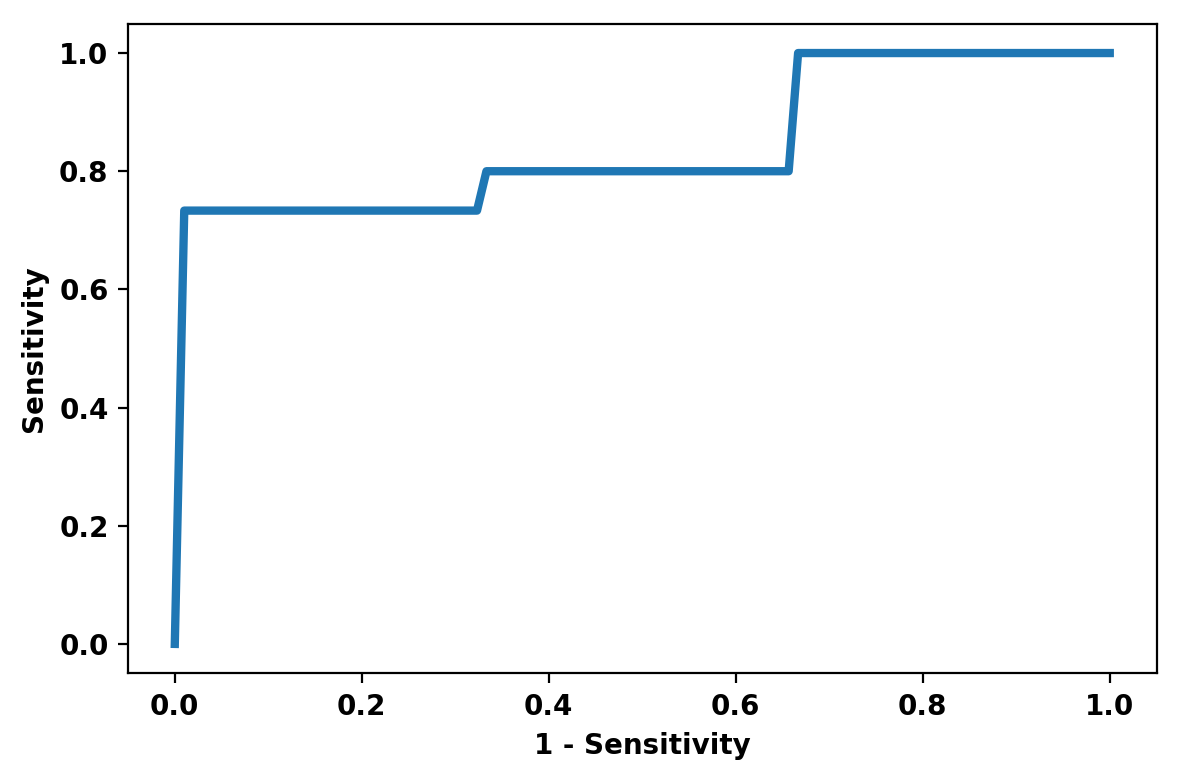

In [14]:
fig,ax=plt.subplots(dpi=200)
ax.plot(fprs,mean_tpr,linewidth=3)
ax.set_ylabel('Sensitivity',fontweight='bold')
ax.set_xlabel('1 - Sensitivity',fontweight='bold')
ax.set_yticklabels([np.round(k,2) for k in ax.get_yticks()],fontweight='bold')
g = ax.set_xticklabels([np.round(k,2) for k in ax.get_xticks()],fontweight='bold')
fig.tight_layout()
fig.savefig('figures/Treatment_prediction.pdf')